## Creating a graph of n-grams from text data
Looking at the neighbours of a selected word

### Loading the text data

In [1]:
import pandas as pd
import itertools
from collections import Counter

In [2]:
graph_data_path = './Data/graph/'
pickle_data_path = './Data/pickle/'
series_name = 'marseille'
series_name = 'LBDL'
pickle_file = pickle_data_path+series_name+'_texts'+'.pkl'
vocab_file = pickle_data_path+series_name+'_vocab_bow'+'.pkl'
tfidf_file = pickle_data_path+series_name+'_vocab_tfidf'+'.pkl'

In [3]:
text_data = pd.read_pickle(pickle_file)
vocab_data = pd.read_pickle(vocab_file)
tfidf_data = pd.read_pickle(tfidf_file)

In [4]:
# create the set of most used words
#nb_words = 200
#word_set = set(tfidf_data.words[0:nb_words])

###  Selecting documents with particular keywords

## Computing the hirarchical structure 

In [5]:
def find_ngrams(word,df_texts,direction='forward',n_grams=3):
    # find the words that follow (direction='forward') or precede (direction='backward')
    # the keyword 'word' in the texts 'texts'
    # n_grams: number of successive words
    # return 
    # * A list of Pandas dataframes 
    #   where each PD contain the list of ngrams with their occurence
    # * the list of texts where the word has been found
    # Example:
    #         word_list,texts_list = find_neighbours(word,texts,direction='forward')
    neighbour_list = []
    list_texts_subset = []
    list_of_ngram_list = []
    for n in range(n_grams):
        list_of_ngram_list.append([])
    #print(word)
    for index,row in df_texts.iterrows():
        #print(row)
        text = row.filtered_text
        if (not pd.isnull(text)):
            text = text.lower()
            wordlist = str(text).split()
            if direction=='forward':
                pass
            elif direction=='backward':
                wordlist.reverse()
            else :
                raise NameError('Unknown direction. Only \'forward\' or \'backward\' are allowed.')
            if len(set(wordlist)&set([word]))>0:
                word_indices = [i for i, x in enumerate(wordlist) if x == word]
                list_texts_subset.append(index)
                for word_ind in word_indices:
                    word_chain = chain_of_grams(word_ind,wordlist,n_grams)
                    #word_chain = ' '.join(word_chain)
                    list_of_ngram_list = append_chain(list_of_ngram_list,word_chain)
                    #neighbour_list.append(wordlist[word_ind+1])
    df_texts_subset =df_texts.loc[list_texts_subset]
    list_of_ngram_df_merged = merge_ngrams(list_of_ngram_list)
    return list_of_ngram_df_merged,df_texts_subset

In [6]:
def chain_of_grams(word_ind,wordlist,n_grams):
    # chain the words that follow the word in wordlist with index word_ind
    # n_grams give length of the chain
    # return a list of words
    n = 0
    word_chain = []
    while (n<=n_grams and (word_ind+n<len(wordlist))):
        word_chain.append(wordlist[word_ind+n])
        n+=1
    return word_chain

In [7]:
def append_chain(list_of_ngram_list,word_chain):
    # for each dataframe, corresponding to the n-grams
    # turn the list of words into a string of the size of the n-gram
    # add it to its dataframe
    for n in range(len(word_chain)-1):
        n_gram = ' '.join(word_chain[:n+1])
        list_of_ngram_list[n].append(n_gram)
    return list_of_ngram_list

In [8]:
def merge_ngrams(list_of_ngram_list):
    # merge the diplucates in all the dataframes of n-grams
    # return a list of dataframe, one for each n-gram length
    # each dataframe has two columns, one with the n-gram, one with its occurence
    list_of_ngram_df_merged = []
    for n in range(len(list_of_ngram_list)):
        list_of_ngram_df_merged.append([])
    for n in range(len(list_of_ngram_list)):
        N_uniquedic = Counter(list_of_ngram_list[n])
        # optionally: filter the dic for removing the lowest values
        N_words = {k:v for (k,v) in N_uniquedic.items() if v > 0}
        Ndf = pd.DataFrame(list(N_words.items()), columns=['ngram','nb_occur'])
        Ndf = Ndf.sort_values('nb_occur',ascending=False)
        Ndf = Ndf.reset_index(drop=True)
        list_of_ngram_df_merged[n] = Ndf
    return list_of_ngram_df_merged

### Word to search for

In [91]:
candidat_word = "secret"
# Number n of n-grams
n_grams = 7
print('Search for the candidat word')
list_of_ngram_df_merged,df_texts_subset = find_ngrams(candidat_word,text_data,
                                                      direction='forward',n_grams=n_grams)
nb_occur = list_of_ngram_df_merged[0].nb_occur[0]
print('Number of occurence of \'{}\' : {}'.format(candidat_word,nb_occur))

Search for the candidat word
Number of occurence of 'secret' : 1111


### Creating the graph

In [92]:
import networkx as nx
import matplotlib.pyplot as plt

In [126]:
print('Create the graph and add the root node \'{}\'.'.format(candidat_word))
G = nx.DiGraph()
# root word
layer_id=0
parent = ''
candidat_id = '_'+candidat_word
# compute the number of occurences of the word:
nb_occur = int(list_of_ngram_df_merged[0].nb_occur[0])
#nb_occur = 0
G.add_node(candidat_id,name=candidat_word, occur=nb_occur)

Create the graph and add the root node 'secret'.


In [127]:
def add_node_layer(ngram_df,threshold=0,popularity=False):
    # Add all the nodes of a layer
    # Add them only if the nb of occur is above the threshold
    # ngram_df is the dataframe containing the ngrams with their occurence
    # layer is the graph layer ()
    for idx,row in ngram_df.iterrows():
        word_list = row.ngram.split()
        if len(word_list)<2:
            raise NameError('n-grams in the dataframe must be longer than 1')
        nb_occur = row.nb_occur
        #print(row.ngram)
        word = word_list[-1]
        path_word = '_'.join(word_list[:-1])
        parent_word = word_list[-2]
        path_parent = '_'.join(word_list[:-2])
        if len(word_list)<3:
            grand_parent=''
        else:
            grand_parent = word_list[-3]
        word_id = path_word+'_'+word
        parent_id = path_parent+'_'+parent_word
        if nb_occur>=threshold and G.has_node(parent_id):
            G.add_node(word_id,name=word, occur=nb_occur)
            G.add_edge(parent_id, word_id, weight=nb_occur)
        if popularity:
            if idx>=popularity-1:
                break

In [128]:
print('Add children nodes in the {}-grams dataset.'.format(n_grams))
for n in range(len(list_of_ngram_df_merged[1:])):
    layer = n+1
    ngram_df = list_of_ngram_df_merged[layer]
    add_node_layer(ngram_df,threshold=5,popularity=15**layer)

Add children nodes in the 7-grams dataset.


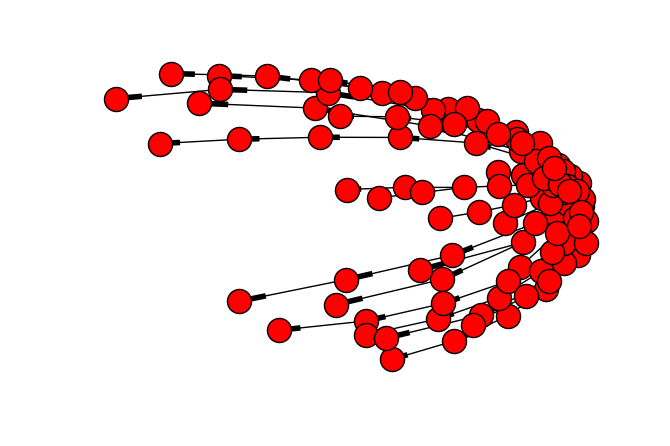

In [129]:
nx.draw_spring(G)
plt.show()

In [130]:
G.size()

104

In [121]:
#G.in_degree()

### Properties of the edges

In [122]:
# Extracting the edge information
#sum_weight = 0
#n_edges = 0
#for u,v,a in G.edges(data=True):
#    sum_weight+=a['weight']
#    n_edges+=1
#average_weight = sum_weight*1.0/n_edges

In [123]:
# Node properties: degree and centrality
degreeDic = G.degree(weight='weight')
nx.set_node_attributes(G,'degree',degreeDic)
bcDic = nx.betweenness_centrality(G)
nx.set_node_attributes(G,'bCentrality',bcDic)

### Saving the graph

In [124]:
# Write the graph to a json file
from networkx.readwrite import json_graph
datag = json_graph.tree_data(G,root=candidat_id)
import json
s = json.dumps(datag)
#datag['links'] = [
#        {
#            'source': datag['nodes'][link['source']]['id'],
#            'target': datag['nodes'][link['target']]['id']
#        }
#        for link in datag['links']]
s = json.dumps(datag)
with open("./viz/treegraph"+series_name+".json", "w") as f:
    f.write(s)

### Open a web page for visualization

In [125]:
import webbrowser
url = 'http://localhost:8008/treegraphmarseille.html'
url = 'http://localhost:8008/treegraphLBDL.html'
#webbrowser.open_new_tab(url)
webbrowser.open_new(url)

True

In [ ]:
G.edges(data='weight')

In [ ]:
print('Add children nodes in the {}-grams dataset.'.format(n_grams))
ngram_df = list_of_ngram_df_merged[n_grams-1]
for idx,row in ngram_df.iterrows():
    word_list = row.ngram.split()
    #print(row.ngram)
    for idx,word in enumerate(word_list):
        if idx == 0:
            grand_parent = ''
        else:
            parent_word = word_list[idx-1]
            word_id = word+parent_word+str(idx)
            if G.has_node(word_id):
                G.node[word_id]['occur'] += 1
                #nx.set_node_attributes(G, 'occur', G.node[word_id]['occur']+1)
            else:
                G.add_node(word_id,name=word, occur=1)
            parent_id = parent_word+grand_parent+str(idx-1)
            if G.has_edge(parent_id,word_id):
                # we added this one before, just increase the weight by one
                G[parent_id][word_id]['weight'] += 1
            else:
                # new edge. add with weight=1
                G.add_edge(parent_id, word_id, weight=1)
            grand_parent = parent_word
            if idx == len(word_list)-1:
                G.node[word_id]['occur'] = row.nb_occur

In [ ]:
clusterDic

In [ ]:
neighbour_data1,df_texts_subset1 = top_neighbours('peau',df_texts_list,direction='forward',top_n=10)
print(neighbour_data1.head(1))
neighbour_data2,df_texts_subset2 = top_neighbours(neighbour_data1.head(1).word[0],df_texts_subset1,direction='forward',top_n=10)
print(neighbour_data2.head(1))
neighbour_data3,df_texts_subset3 = top_neighbours(neighbour_data2.head(1).word[0],df_texts_subset2,direction='forward',top_n=10)

#neighbour_data2,texts_subset2 = top_neighbours(neighbour_data.head(1).word[0],texts_subset1,direction='forward',top_n=10)


In [ ]:
df_texts_subset2.text.loc[11060]

In [ ]:
neighbour_data1,texts_subset1 = top_neighbours('égalité',text_data.filtered_text,direction='forward',top_n=10)
print(neighbour_data1.head(1))
neighbour_data2,texts_subset2 = top_neighbours(neighbour_data1.head(1).word[0],texts_subset1,direction='forward',top_n=10)
print(neighbour_data2.head(1))
neighbour_data3,texts_subset3 = top_neighbours(neighbour_data2.head(1).word[0],texts_subset2,direction='forward',top_n=10)


In [ ]:
texts_subset3